In [1]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.stats as stats
import pingouin as pg

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/crop_mapping/WinnipegDataset.csv')

In [3]:
# Selected subset of potentially useful features (all from 05 July data)
labels = {
    'label': 'class',
    'f1': 'sigHH',
    'f2': 'sigHV',
    'f3': 'sigVV',
    'f7': 'Rhhvv',
    'f8': 'Rhvhh',
    'f9': 'Rhvvv',
    'f25': 'l1',
    'f26': 'l2',
    'f27': 'l3',
    'f28': 'H',
    'f29': 'A',
    'f30': 'a',
    'f31': 'HA',
    'f32': 'H1mA',
    'f33': '1mHA',
    'f34': '1mH1mA',
    'f35': 'PH',
    'f36': 'rvi',
    'f37': 'paulalpha',
    'f38': 'paulbeta',
    'f39': 'paulgamma',
    'f40': 'krogks',
    'f41': 'krogkd',
    'f42': 'krogkh',
    'f43': 'freeodd',
    'f44': 'freedbl',
    'f45': 'freevol',
    'f46': 'yamodd',
    'f47': 'yamdbl',
    'f48': 'yamhlx',
    'f49': 'yamvol',
    'f99': 'B',
    'f100': 'G',
    'f101': 'R',
    'f102': 'Redge',
    'f103': 'NIR'
}
features = list(labels.values())

In [4]:
df = df.rename(columns=labels)
df = df.dropna()
df = df[features]

In [5]:
# Grouping features by prefix to determine nodes of graph
node_structure = {
    'sig': ['sigHH', 'sigHV', 'sigVV'],
    'R': ['Rhhvv', 'Rhvhh', 'Rhvvv'],
    'L': ['l1', 'l2', 'l3'],
    'PH': ['PH'],
    'rvi': ['rvi'],
    'paul': ['paulalpha, paulbeta, paulgamma'],
    'krog': ['krogks', 'krogkd', 'krogkh'],
    'free': ['freeodd', 'freedbl', 'freevol'],
    'yam': ['yamodd', 'yamdbl', 'yamhlx', 'yamvol'],
    'RGB': ['B', 'G', 'R', 'Redge', 'NIR']
}

In [6]:
df['class'].value_counts()

class
6    85074
3    75673
4    74067
5    47117
1    39162
2     3598
7     1143
Name: count, dtype: int64

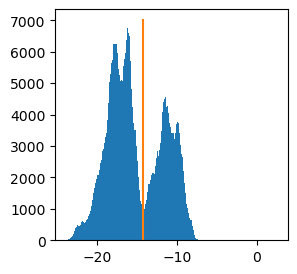

In [7]:
# For the time being we are using a certain segment of the data based on the distribution of sigHH. 
# This segment has univariate feature distributions much closer to Gaussian or log-Gaussian.
threshold = -14.25

fig, ax = plt.subplots(figsize=(3,3))
plt.hist(df['sigHH'], bins = 200)
plt.plot(threshold*np.ones(50), np.linspace(0, 7000, 50))
plt.show()

In [8]:
df_selection = df.loc[df['sigHH'] < threshold].reset_index()

In [9]:
df_selection['class'].value_counts()

class
6    82495
4    72200
5    44815
3     2292
1     1228
2       59
Name: count, dtype: int64

In [10]:
X = df_selection.drop(['class'], axis=1)
y = df_selection['class']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify=df_selection['class']
)
train_index = X_train.index
test_index = X_test.index

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

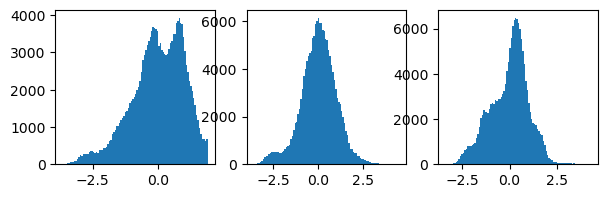

In [12]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes[0].hist(X_train['sigHH'], bins = 100)
axes[1].hist(X_train['sigHV'], bins = 100)
axes[2].hist(X_train['sigVV'], bins = 100)
plt.show()

In [13]:
# Start collecting new features

df_transformed = pd.concat([
    X['sigHH'].reset_index(drop=True), 
    X['sigHV'].reset_index(drop=True), 
    X['sigVV'].reset_index(drop=True)
], axis=1)

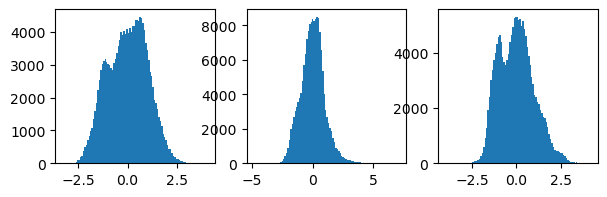

In [14]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes[0].hist(X_train['Rhhvv'], bins = 100)
axes[1].hist(X_train['Rhvhh'], bins = 100)
axes[2].hist(X_train['Rhvvv'], bins = 100)
plt.show()

In [15]:
df_transformed = pd.concat([
    df_transformed,
    X['Rhhvv'].reset_index(drop=True),
    X['Rhvhh'].reset_index(drop=True), 
    X['Rhvvv'].reset_index(drop=True)
], axis=1)

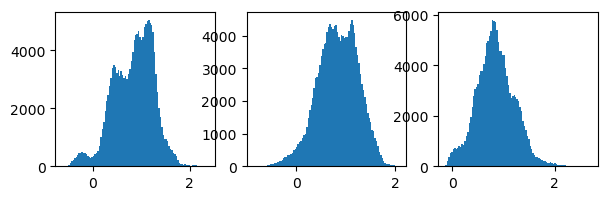

In [16]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes[0].hist(np.log(X_train['l1'] + 2.5), bins = 100)
axes[1].hist(np.log(X_train['l2'] + 2.5), bins = 100)
axes[2].hist(np.log(X_train['l3'] + 2.5), bins = 100)
plt.show()

In [17]:
df_transformed = pd.concat([
    df_transformed,
    np.log(X['l1'] + 2.5).rename('l1_lg').reset_index(drop=True),
    np.log(X['l2'] + 2.5).rename('l2_lg').reset_index(drop=True),
    np.log(X['l3'] + 2.5).rename('l3_lg').reset_index(drop=True)
], axis=1)

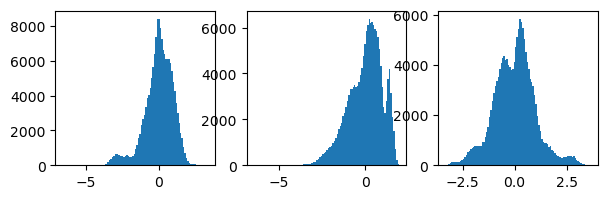

In [18]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes[0].hist(X_train['H'], bins = 100)
axes[1].hist(X_train['A'], bins = 100)
axes[2].hist(X_train['a'], bins = 100)
plt.show()

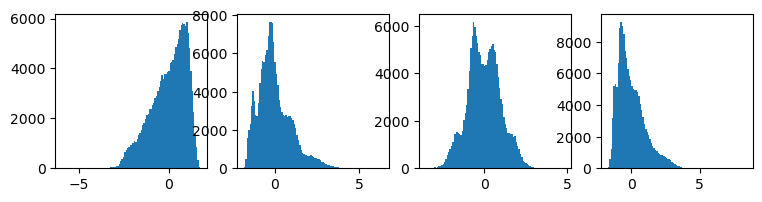

In [19]:
fig, axes = plt.subplots(1,4, figsize=(9,2))
axes[0].hist(X_train['HA'], bins = 100)
axes[1].hist(X_train['H1mA'], bins = 100)
axes[2].hist(X_train['1mHA'], bins = 100)
axes[3].hist(X_train['1mH1mA'], bins = 100)
plt.show()

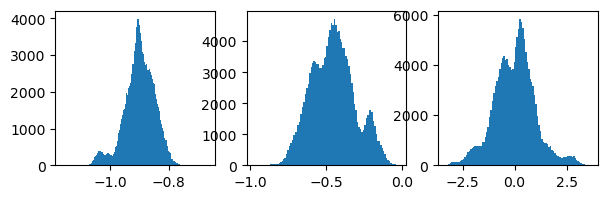

In [20]:
fig, axes = plt.subplots(1,3,figsize=(7,2))
axes[0].hist(-np.log10(8 - X_train['H']), bins=200)
axes[1].hist(-np.log10(3 - X_train['A']), bins=100)
axes[2].hist(X_train['a'], bins=100)
plt.show()

In [21]:
df_transformed = pd.concat([
    df_transformed,
    -np.log10(8 - X['H']).rename('H_lg').reset_index(drop=True),
    -np.log10(3 - X['A']).rename('A_lg').reset_index(drop=True),
    X['a'].reset_index(drop=True)
], axis=1)

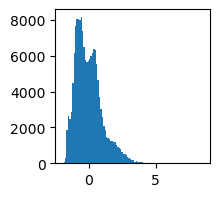

In [22]:
fig, ax = plt.subplots(figsize=(2,2))
plt.hist(X_train['PH'], bins=100)
plt.show()

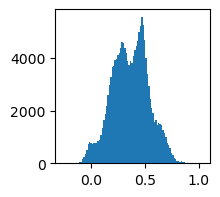

In [23]:
fig, ax = plt.subplots(figsize=(2,2))
plt.hist(np.log10(X_train['PH'] + 2.5), bins=100)
plt.show()

In [24]:
df_transformed = pd.concat([
    df_transformed,
    np.log10(X['PH'] + 2.5).rename('PH_lg').reset_index(drop=True),
], axis=1)

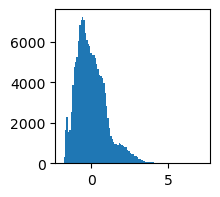

In [25]:
fig, ax = plt.subplots(figsize=(2,2))
plt.hist(X_train['rvi'], bins=100)
plt.show()

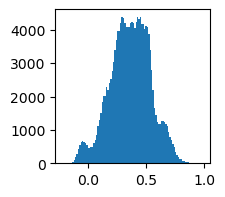

In [26]:
fig, ax = plt.subplots(figsize=(2,2))
plt.hist(np.log10(X_train['rvi'] + 2.5), bins=100)
plt.show()

In [27]:
df_transformed = pd.concat([
    df_transformed,
    np.log10(X['rvi'] + 2.5).rename('rvi_lg').reset_index(drop=True),
], axis=1)

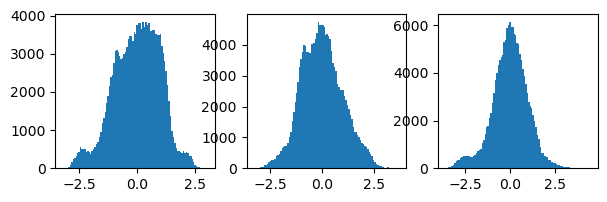

In [28]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes[0].hist(X_train['paulalpha'], bins = 100)
axes[1].hist(X_train['paulbeta'], bins = 100)
axes[2].hist(X_train['paulgamma'], bins = 100)
plt.show()

In [29]:
df_transformed = pd.concat([
    df_transformed,
    X['paulalpha'].reset_index(drop=True),
    X['paulbeta'].reset_index(drop=True),
    X['paulgamma'].reset_index(drop=True)
], axis=1)

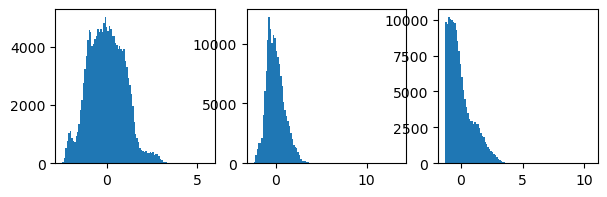

In [30]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes[0].hist(X_train['krogks'], bins = 100)
axes[1].hist(X_train['krogkd'], bins = 100)
axes[2].hist(X_train['krogkh'], bins = 100)
plt.show()

In [31]:
# Drop krogkh since the selection cannot be transformed to a normal distribution
df_transformed = pd.concat([
    df_transformed,
    X['krogks'].reset_index(drop=True),
    X['krogkd'].reset_index(drop=True),
], axis=1)

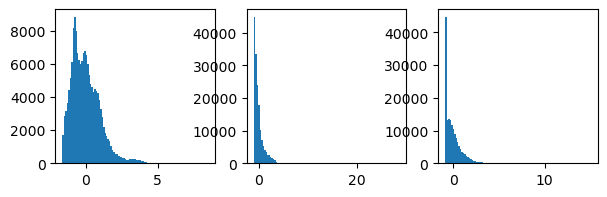

In [32]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes[0].hist(X_train['freeodd'], bins = 100)
axes[1].hist(X_train['freedbl'], bins = 100)
axes[2].hist(X_train['freevol'], bins = 100)
plt.show()

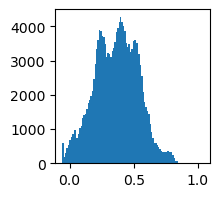

In [33]:
fig, ax = plt.subplots(figsize=(2,2))
plt.hist(np.log10(X_train['freeodd'] + 2.5), bins=100)
plt.show()

In [34]:
df_transformed = pd.concat([
    df_transformed,
    np.log10(X['freeodd'] + 2.5).rename('freeodd_lg').reset_index(drop=True)
], axis=1)

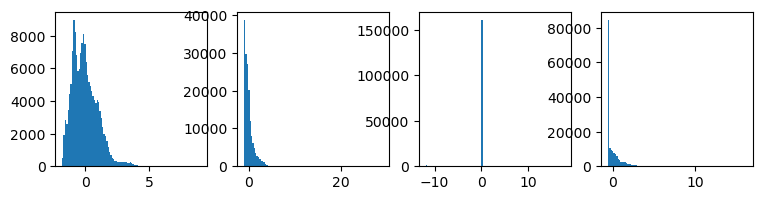

In [35]:
fig, axes = plt.subplots(1,4, figsize=(9,2))
axes[0].hist(X_train['yamodd'], bins = 100)
axes[1].hist(X_train['yamdbl'], bins = 100)
axes[2].hist(X_train['yamhlx'], bins = 100)
axes[3].hist(X_train['yamvol'], bins = 100)
plt.show()

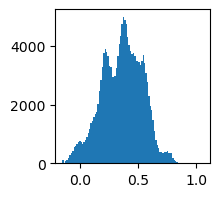

In [36]:
fig, ax = plt.subplots(figsize=(2,2))
plt.hist(np.log10(X_train['yamodd'] + 2.5), bins=100)
plt.show()

In [37]:
df_transformed = pd.concat([
    df_transformed,
    np.log10(X['yamodd'] + 2.5).rename('yamodd_lg').reset_index(drop=True)
], axis=1)

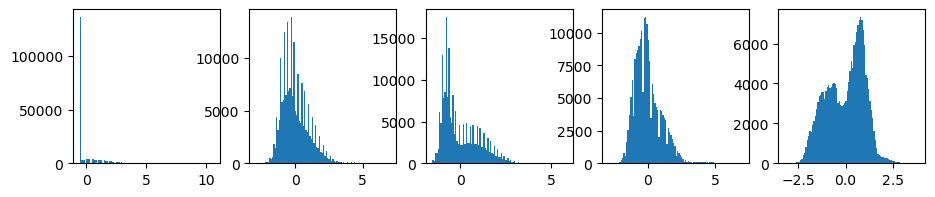

In [38]:
fig, axes = plt.subplots(1,5, figsize=(11,2))
axes[0].hist(X['B'], bins = 100)
axes[1].hist(X['G'], bins = 100)
axes[2].hist(X['R'], bins = 100)
axes[3].hist(X['Redge'], bins = 100)
axes[4].hist(X['NIR'], bins = 100)
plt.show()

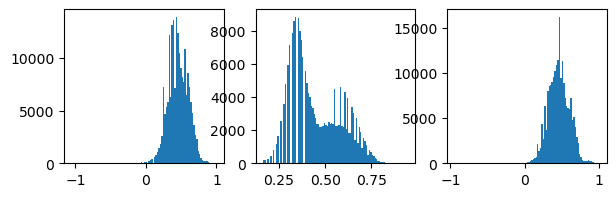

In [39]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes[0].hist(np.log10(X['G'] + 3), bins = 100)
axes[1].hist(np.log10(X['R'] + 3), bins = 100)
axes[2].hist(np.log10(X['Redge'] + 3), bins = 100)
plt.show()

In [40]:
df_transformed = pd.concat([
    df_transformed,
    np.log10(X['G'] + 3).rename('G_lg').reset_index(drop=True),
    np.log10(X['R'] + 3).rename('R_lg').reset_index(drop=True),
    np.log10(X['Redge'] + 3).rename('Redge_lg').reset_index(drop=True),
    X['NIR'].reset_index(drop=True)
], axis=1)

In [41]:
# Normalize again and include class labels

df_tr_scaler = StandardScaler()
df_tr_scaler.fit(df_transformed)

df_transformed = pd.concat([
    df_selection['class'].reset_index(drop=True),
    pd.DataFrame(df_tr_scaler.transform(df_transformed), columns=df_transformed.columns)
], axis = 1)

In [42]:
df_transformed

,class,sigHH,sigHV,sigVV,Rhhvv,Rhvhh,Rhvvv,l1_lg,l2_lg,l3_lg,...,paulbeta,paulgamma,krogks,krogkd,freeodd_lg,yamodd_lg,G_lg,R_lg,Redge_lg,NIR
0,1,1.534650,2.784447,4.115965,-3.133641,2.861733,-0.630674,3.662855,1.363474,1.810357,...,3.719510,2.784447,3.371244,5.128501,-0.338141,1.782217,-0.194133,0.533661,-1.558487,-1.874834
1,1,1.639179,2.424456,3.438106,-2.169777,2.022738,-0.411114,3.031564,1.702457,2.289760,...,3.017513,2.424456,3.096686,4.036456,3.111913,2.614659,0.722445,0.776335,0.590974,-0.755381
2,1,1.280794,2.302097,3.276544,-2.420645,2.347731,-0.401689,2.835934,1.424706,2.040427,...,2.833735,2.302097,2.608307,3.498448,2.838282,2.346488,1.958623,1.253152,2.037725,-0.500960
3,1,1.756343,2.919561,3.845524,-2.524155,2.772912,-0.216005,3.404475,1.834172,2.564587,...,3.341469,2.919561,3.229521,4.213299,0.143446,2.729619,-0.033991,0.271076,-0.642645,-0.826619
4,1,0.948829,1.993600,2.962200,-2.450188,2.280849,-0.466004,2.496939,1.201883,1.752274,...,2.439138,1.993600,2.152026,3.001045,2.512647,2.040327,0.401560,0.533661,0.686464,-0.908034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203084,6,-0.087271,-0.299099,-0.406024,0.389455,-0.427897,0.033273,-0.501971,0.223679,-0.131449,...,-0.179003,-0.299099,0.140243,0.296632,0.150897,0.113062,-1.384908,-0.329128,-1.558487,-0.979272
203085,6,0.023001,-0.053908,-0.232169,0.313382,-0.136478,0.156526,-0.282775,0.246421,0.067774,...,-0.130989,-0.053908,0.307645,0.340228,0.288748,0.255839,-1.508683,-0.329128,-1.463139,-0.999626
203086,6,0.070671,0.130340,-0.188266,0.319787,0.136110,0.331619,-0.211569,0.244325,0.293804,...,-0.180658,0.130340,0.509613,0.384412,0.465141,0.435745,-0.934516,-0.136968,-1.108559,-0.928388
203087,6,0.230911,0.200732,-0.120363,0.436861,0.020289,0.349639,-0.025291,0.227273,0.382075,...,-0.190592,0.200732,0.982683,0.744830,0.804130,0.741242,-0.731962,0.482839,0.005849,-0.857150


In [43]:
df_transformed_train = df_transformed.iloc[train_index]
df_transformed_test = df_transformed.iloc[test_index]

In [44]:
# Summarize the transformed features within nodes
df_transformed_node_structure = {
    'sig': ['sigHH', 'sigHV', 'sigVV'],
    'R': ['Rhhvv', 'Rhvhh', 'Rhvvv'],
    'L': ['l1_lg', 'l2_lg', 'l3_lg'],
    'HA': ['H_lg', 'A_lg', 'a'],
    'PH': ['PH_lg'],
    'rvi': ['rvi_lg'],
    'paul': ['paulalpha', 'paulbeta', 'paulgamma'],
    'krog': ['krogks', 'krogkd'],
    'free': ['freeodd_lg'],
    'yam': ['yamodd_lg'],
    'RGB': ['G_lg', 'R_lg', 'Redge_lg', 'NIR']
}

In [45]:
with open('../data/crop_mapping/Winnipeg_selection_nodes.json', 'w') as fp:
    json.dump(df_transformed_node_structure, fp)

df_transformed_train.to_csv('../data/crop_mapping/Winnipeg_selection_transformed_train.csv', mode='w', index=False)
df_transformed_test.to_csv('../data/crop_mapping/Winnipeg_selection_transformed_test.csv', mode='w', index=False)